In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["SM_FRAMEWORK"] = "tf.keras"
%matplotlib inline

In [2]:
dataset_train = pd.read_excel('Dataset.xlsx')
cols = list(dataset_train)[2:8]


datelist_train = list(dataset_train['Date'])
datelist_train = [dt.datetime.strptime(date, '%m/%d/%Y').date() for date in datelist_train]

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (105, 9)
All timestamps == 105
Featured selected: ['CodedDay', 'Zone', 'Weather', 'Temperature', 'Rain', 'Holiday']


In [3]:
dataset_train = dataset_train[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')

dataset_train = dataset_train.astype(float)

training_set = dataset_train.values

print('Shape of training set == {}.'.format(training_set.shape))
print(training_set)

Shape of training set == (105, 6).
[[ 7.   1.  17.2 12.6  1.   0. ]
 [ 7.   2.   8.   4.1  0.   0. ]
 [ 7.   3.   9.7  8.3  0.   0. ]
 [ 7.   4.  16.  12.4  1.   0. ]
 [ 7.   5.  16.  12.1  1.   0. ]
 [ 7.   6.  17.  13.   0.   0. ]
 [ 7.   7.  16.  12.3  0.   0. ]
 [ 1.   1.  18.  11.8  1.   0. ]
 [ 1.   2.   8.4  5.6  1.   0. ]
 [ 1.   3.  17.1 10.9  0.   0. ]
 [ 1.   4.  17.3 12.6  1.   0. ]
 [ 1.   5.  15.9 11.6  1.   0. ]
 [ 1.   6.  17.5 13.   0.   0. ]
 [ 1.   7.  16.5 11.5  1.   0. ]
 [ 2.   1.  19.6 12.6  0.   0. ]
 [ 2.   2.   7.2  5.2  1.   0. ]
 [ 2.   3.  18.2 12.4  0.   0. ]
 [ 2.   4.  18.8 13.4  0.   0. ]
 [ 2.   5.  17.7 12.9  0.   0. ]
 [ 2.   6.  19.2 14.2  0.   0. ]
 [ 2.   7.  17.7 12.2  0.   0. ]
 [ 3.   1.  21.2 12.8  0.   0. ]
 [ 3.   2.  10.6  6.   1.   0. ]
 [ 3.   3.  18.9 12.8  0.   0. ]
 [ 3.   4.  20.9 14.6  0.   0. ]
 [ 3.   5.  19.4 14.2  0.   0. ]
 [ 3.   6.  20.5 15.3  0.   0. ]
 [ 3.   7.  19.7 13.6  0.   0. ]
 [ 4.   1.  22.9 13.6  0.   0. ]
 [ 4.   

In [4]:
from sklearn.preprocessing import StandardScaler


sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[ 1.35132785],
       [ 1.35132785],
       [ 1.35132785],
       [ 1.35132785],
       [ 1.35132785],
       [ 1.35132785],
       [ 1.35132785],
       [-1.54437469],
       [-1.54437469],
       [-1.54437469],
       [-1.54437469],
       [-1.54437469],
       [-1.54437469],
       [-1.54437469],
       [-1.0617576 ],
       [-1.0617576 ],
       [-1.0617576 ],
       [-1.0617576 ],
       [-1.0617576 ],
       [-1.0617576 ],
       [-1.0617576 ],
       [-0.57914051],
       [-0.57914051],
       [-0.57914051],
       [-0.57914051],
       [-0.57914051],
       [-0.57914051],
       [-0.57914051],
       [-0.09652342],
       [-0.09652342],
       [-0.09652342],
       [-0.09652342],
       [-0.09652342],
       [-0.09652342],
       [-0.09652342],
       [ 0.38609367],
       [ 0.38609367],
       [ 0.38609367],
       [ 0.38609367],
       [ 0.38609367],
       [ 0.38609367],
       [ 0.38609367],
       [ 0.86871076],
       [ 0.86871076],
       [ 0.86871076],
       [ 0

In [5]:
X_train = []
y_train = []

# 4 is the new number of days, 7 is the number of zones
n_future = 3
n_past = 12

print(len(training_set_scaled))

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

105
X_train shape == (91, 12, 5).
y_train shape == (91, 1).


In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

In [7]:
model = Sequential()

model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, dataset_train.shape[1]-1)))

model.add(LSTM(units=10, return_sequences=False))

model.add(Dropout(0.25))

model.add(Dense(units=1, activation='linear'))

model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')

In [8]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=30, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/30
1/1 [==============================] - ETA: 0s - loss: 0.7538
Epoch 1: val_loss improved from inf to 0.83830, saving model to weights.h5
1/1 [==============================] - 4s 4s/step - loss: 0.7538 - val_loss: 0.8383 - lr: 0.0100
Epoch 2/30
1/1 [==============================] - ETA: 0s - loss: 0.5947
Epoch 2: val_loss improved from 0.83830 to 0.77158, saving model to weights.h5
1/1 [==============================] - 0s 100ms/step - loss: 0.5947 - val_loss: 0.7716 - lr: 0.0100
Epoch 3/30
1/1 [==============================] - ETA: 0s - loss: 0.4388
Epoch 3: val_loss improved from 0.77158 to 0.73154, saving model to weights.h5
1/1 [==============================] - 0s 108ms/step - loss: 0.4388 - val_loss: 0.7315 - lr: 0.0100
Epoch 4/30
1/1 [==============================] - ETA: 0s - loss: 0.3566
Epoch 4: val_loss improved from 0.73154 to 0.66618, saving model to weights.h5
1/1 [==============================] - 0s 92ms/step - loss: 0.3566 - val_loss: 0.6662 - lr: 0.0100


In [9]:
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()

datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

In [10]:
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

In [11]:
def datetime_to_timestamp(x):

    return datetime.strptime(x.strftime('%d%m%Y'), '%d%m%Y')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Date']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Date']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN.head(3)

,Date
2022-02-07,3.282530
2022-02-07,3.533049
2022-02-08,3.813325


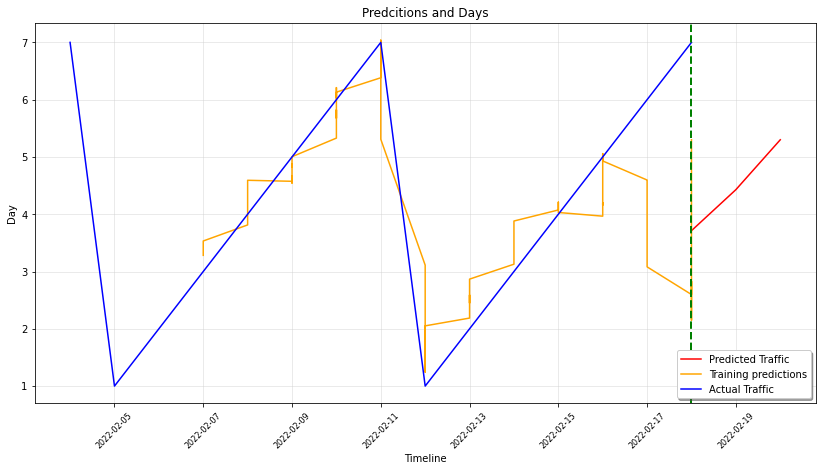

In [16]:
from pylab import rcParams
rcParams['figure.figsize'] = 14, 7

START_DATE_FOR_PLOTTING = '2022-02-01'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Date'], color='r', label='Predicted Traffic')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Date'], color='orange', label='Training predictions')
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['CodedDay'], color='b', label='Actual Traffic')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Days', fontsize=12)
plt.xlabel('Timeline', fontsize=10)
plt.ylabel('Day', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()

In [13]:
dataset_train = pd.DataFrame(dataset_train, columns=cols)
dataset_train.index = datelist_train
dataset_train.index = pd.to_datetime(dataset_train.index)

In [17]:
model.save('LSTM_model.h5')